# How `matplotlib` works?

**Note:** The codes displayed here are *not* exactly the same as the source code. Just to help understanding. But you can easily find the source code in [https://github.com/matplotlib/matplotlib](https://github.com/matplotlib/matplotlib).

## The example code

In [1]:
import matplotlib
from matplotlib import pyplot

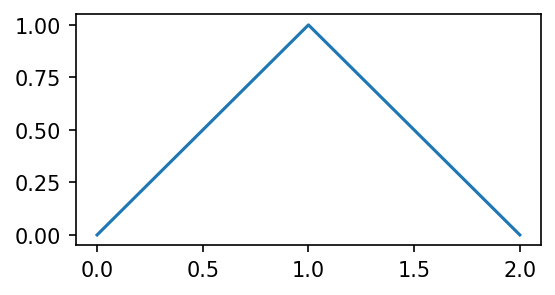

In [2]:
fig = pyplot.figure(figsize=(4,2), dpi=150)
ax = fig.add_subplot() # equivlent to fig, ax = pyplot.subplots()

ax.plot([0,1,2],[0,1,0])

pyplot.show()
pyplot.close('all')

## What happens after `pyplot.figure()`?

### Module `matplotlib.pyplot`:

```python
def figure(...):
    # ...
    if manager is None:
        # ...
        manager = new_figure_manager(...)
        # ...
    return manager.canvas.figure

# ...

def new_figure_manager(...):
    # ...
    return _get_backend_mod().new_figure_manager(...)
```

What is a **backend**?

In [3]:
print("current backend:", matplotlib.get_backend())

current backend: module://matplotlib_inline.backend_inline


### Module `matplotlib.backend_bases`
```python
class _Backend:
    # ...
    @classmethod
    def new_figure_manager(cls, ...):
        # ...
        fig = matplotlib.figure.Figure(...) # create figure
        return cls.new_figure_manager_given_figure(fig, ...)
    
    @classmethod
    def new_figure_manager_given_figure(cls, figure, ...):
        # ...
        return cls.FigureCanvas.new_manager(figure, ...)
    
# ...

class FigureCanvasBase:
    # ...
    @classmethod
    def new_manager(cls, figure, ...):
        # ...
        return FigureManagerBase.create_with_canvas(cls, figure, ...)
    
# ...

class FigureManagerBase:
    # ...
    def create_with_canvas(cls, canvas_class, figure, ...):
        # ...
        return cls(canvas_class(figure), ...) # create canvas then manager
```

![alt text](chart/Slide1.png "Title")

## What happens after `fig.add_subplots()`? (Finally the 2nd line!)

### Module `matplotlib.figure`

```python
class FigureBase(Artist):
    # ...
    def add_subplot(self, ...):
        # ...
        ax = subplot_class_factory(projection_class)(self, ...)
        # ...
```
By default, `projection_class = matplotlib.Axes`, but also can be `"polar"`, `"Axes3D"`, etc., specified by `subplot_kw={"projection": "polar"}` or `projection="3d"`.


In this case, the code above is equivalent to 

```python
class FigureBase(Artist):
    # ...
    def add_subplot(self, ...):
        # ...
        ax = matplotlib.Axes(self, ...)
        # ...
```

![alt text](chart/Slide2.png "Title")

## What happens after `ax.plot()`?

### Module `matplotlib.axes`

```python
class Axes(_AxesBase):
    # ...
    def plot(self, ...):
        # ...
        lines = [*self._get_lines(...)]
        for line in lines:
            self.add_line(line)
        # ...
        return lines
    
    def add_line(self, line):
        # ...
        self._children.append(line)
        # ...
```

![alt text](chart/Slide3.png "Title")

## What happens after `pyplot.show()`?

### Module `matplotlib.pyplot`
```python
def show(...):
    # ...
    return _get_backend_mod().show(...)
```

This really depends on the backend. For our case, the current backend is

### Module `matplotlib-inline.backend_inline`
```python
def show(...):
    # ...
    for figure_manager in Gcf.get_all_fig_managers():
        IPython.display(figure_manager.canvas.figure, ...)
    # ...
```

![alt text](chart/Slide4.png "Title")

It's too complicated when dealing with GUI. Let's consider a non-GUI case.

## What happens after `fig.savefig()`?

### Module `matplotlib.Figure`
```python
class Figure(FigureBase):
    # ...
    def savefig(self, fname, ...):
        # ...
        self.canvas.print_figure(fname, ...)
```

### Module `matplotlib.backend_bases`
```python
class FigureCanvasBase:
    # ...
    def print_figure(self, filename, format, backend, ...):
        # ...
        print_method = self._switch_canvas_and_return_print_method(format, backend)
        result = print_method(filename, ...)
        # ...
        return result
```

## Example: format = "png"

In this case, `_switch_canvas_and_return_print_method()` returns a function object: `FigureCanvasAgg.print_png`

### Module `matplotlib.backends.backend_agg`
```python
class FigureCanvasAgg(FigureCanvasBase):
    # ...
    def print_png(self, filename_or_obj, ...):
        # ...
        self._print_pil(filename_or_obj, "png", ...)
        
    def _print_pil(self, filename_or_obj, fmt, ...):
        # ...
        FigureCanvasAgg.draw(self)
        matplotlib.image.imsave(filename_or_obj, format=fmt, ...)
        
    def draw(self):
        # ...
        self.figure.draw(self.get_renderer())
        # ...
```


### Module `matplotlib.Figure`
```python
class Figure(FigureBase):
    # ...
    def draw(self, renderer):
        # ...
        artists = self._get_draw_artists(renderer)
        # ...
        for a in artists:
            a.draw(renderer)
        # ...
        
# ...

class FigureBase(Artist):
    def _get_draw_artists(self, renderer):
        # ...
        artists = self.get_children()
        # ...
        return artists
```

## Example: draw a line

### Module `matplotlib.lines`
```python
class Line2D(Artist):
    # ...
    def draw(self, renderer):
        # ...
        tpath, affine = (self._get_transformed_path()
                         .get_transformed_path_and_affine())
        # ...
        renderer.draw_path(..., tpath, affine.frozen())
        # ...
```

What is a **path**?

What is a **renderer**?

In [4]:
line = ax._children[0]
tpath, affine = (line._get_transformed_path()
                 .get_transformed_path_and_affine())

print(tpath)
print(affine)

Path(array([[0., 0.],
       [1., 1.],
       [2., 0.]]), None)
Affine2D(
    [[211.36363636   0.          96.13636364]
     [  0.         210.          43.5       ]
     [  0.           0.           1.        ]])


In [5]:
print(affine.transform(tpath.vertices))

[[ 96.13636364  43.5       ]
 [307.5        253.5       ]
 [518.86363636  43.5       ]]


In [6]:
print(fig)

Figure(600x300)


In [7]:
print(fig.canvas.get_renderer())


### Module `matplotlib._backend_agg`

The C++ AGG library is developed by Maxim Shemanarev: [https://github.com/ghaerr/agg-2.6](https://github.com/ghaerr/agg-2.6)

```c++
class RendererAgg
{
  public:
    // ...
    // Not exactly the same, just to help understand the source code.
    agg::rasterizer_scanline_aa<agg::rasterizer_sl_clip_dbl> theRasterizer
    // ...
  protected:
    // ...
    template <class PathIteratorType>
    void _draw_path(PathIteratorType &path, ...);
    // ...
}

// ...

template <class path_t>
inline void
RendererAgg::_draw_path(path_t &path, ...)
{
    // ...
    agg::conv_stroke<path_t> stroke(path);
    // ...
    theRasterizer.add_path(stroke); 
    // ... 
    agg::render_scanlines(theRasterizer, ...);
    // ...
}
```

## A ready-to-use backend only needs 3 functions!

* `draw_path()` to render `Path` objects
* `draw_text()` to render `Text` objects
* `draw_image()` to render `Image` objects

![alt text](chart/Slide5.png "Title")